<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Project_2_9_Potatoe_disease_classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Potatoes Disease Classification

Potatoes are a key vegetable grown worldwide, and are a staple of many diets. But many diseases affect their production, most notoriously blight. For this assignment, we will be given images of potato leaves that have two different kinds of blight (Early blight and Late blight) and healthy leaves. Our task will be to make a classifier that can tell them apart.

**Prepare the Environment**

In [ ]:
import os

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, models, transforms

# Important! Don't change this
torch.backends.cudnn.deterministic = True

We'll be making large networks, so we'll get the GPU if it's available.

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

#output
Using cuda device.


### Load and Explore the Data

In [ ]:
!ls -l potato_dataset/

#output
total 8
drwxr-xr-x 3 root root 4096 Nov 14 11:56 test
drwxr-xr-x 5 root root 4096 Nov 14 11:56 train

This has created a directory called `potato_dataset`. In there we have a directory called `train` and a directory called `test`. In the `train` directory, images from each class are contained in separate subdirectories, where the name of each subdirectory is the name of the class.

Our ultimate goal in this assignment is to train our classification model, and then submit predictions about the `test` images to the grader.

For start, let's explore the data a bit!

**Task 2.7.1:** Make a list of the names of the classes we'll be working with.

In [ ]:
train_dir = os.path.join('potato_dataset', 'train')
classes = os.listdir(train_dir)

print(classes)
print(f"Number of classes: {len(classes)}")

#output
['Potato_Late_blight', 'Potato_healthy', 'Potato_Early_blight']
Number of classes: 3

Now we're ready to start preparing our dataset. For now, let's use the following set of transformations:

- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$)
- Convert the image to a Tensor of pixel values

**Task 2.7.2:** Create the transformation pipeline with steps listed above by using `transforms.Compose` from the `torchvision` package.

In [ ]:
height = 224
width = 224


class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img


transform = transforms.Compose(
     [
        ConvertToRGB(),
        transforms.Resize((height, width)),
        transforms.ToTensor()
    ]
)

print(transform)

#output
Compose(
    <__main__.ConvertToRGB object at 0x781ddc454b10>
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Let's create the dataset and apply our transformations.

**Task 2.7.3:** Make a dataset using `ImageFolder` from `datasets` and make sure to apply the `transform` transformation pipeline.

In [ ]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

print("Length of dataset:", len(dataset))

#output
Length of dataset: 421


Notice how small this training data is, we have just 421 images in total.

**Task 2.7.4:** Use this dataset to create a `DataLoader` with batch size 32.

In [ ]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

#output
Getting batches of shape: torch.Size([32, 3, 224, 224])


Now we can think about normalizing our dataset, so each color channel has a mean of $0$ and a standard deviation of $1$. In order to do this, we first need to get the mean and standard deviation of each channel in this dataset.

The `get_mean_std` function we used in the lessons is included in the `training.py` file for this assignment. Let's import it.

In [ ]:
from training import get_mean_std

**Task 2.7.5:** Use function `get_mean_std` described above and calculate the mean and standard deviation of each channel in this dataset.

In [ ]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

#output
Mean: tensor([0.4938, 0.5135, 0.4351])
Standard deviation: tensor([0.1843, 0.1563, 0.2023])

Great! Now we can improve our original transformation pipeline. We'll take the previous one, and add normalization of the channels according to the mean and standard deviation you computed in the previous task. Our transformations should now look like:

- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$)
- Convert the image to a Tensor of pixel values
- Normalize the data using `transforms.Normalize`

**Task 2.7.6:** Build this new transformation pipeline.

In [ ]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]

)

print(transform_norm)

#output
Compose(
    <__main__.ConvertToRGB object at 0x76da347ba350>
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.4938, 0.5135, 0.4351]), std=tensor([0.1843, 0.1563, 0.2023]))
)

**Task 2.7.7:** Create a normalized data set, using the transformation pipeline from the previous task. Also split the normalized data set into a training set and a validation set. 80% of the data should be in the training set, and 20% in the validation set.

In [ ]:
# Important! don't change this.
g = torch.Generator()
g.manual_seed(42)

norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)

# Important, DON'T change the `generator=g` parameter
train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2], generator=g)

print("Length of dataset:", len(norm_dataset))
print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

#output
Length of dataset: 421
Training data set size: 337
Validation data set size: 84

Now let's create `DataLoader` objects. We'll use a batch size of 32 and create one `DataLoader` for training and another for validation data.

**Task 2.7.8:** Create the training loader (with shuffling on) and the validation loader (with shuffling off).

In [ ]:
# Important! don't change this.
g = torch.Generator()
g.manual_seed(42)

batch_size = 32

# Important! Don't change the `generator=g` parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(type(train_loader))
print(type(val_loader))

#output
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>

### Defining and Training a Model

We'll start by building a convolutional neural network from scratch.

**Task 2.7.9:** Fill in the missing code below to define a neural network with the following layers:
- 2D convolution with **sixteen** $3\times3$ kernels
- Max pooling with $4\times4$ kernels (and a stride of $4\times4$)
- ReLU activation
- 2D convolution with **thirty-two** $3\times3$ kernels
- Max pooling with $4\times4$ kernels
- ReLU activation
- 2D convolution with **sixty-four** $3\times3$ kernels
- Max pooling with $4\times4$ kernels
- ReLU activation
- Flattening
- Drop-out
- Linear layer with $500$ outputs
- ReLU activation
- Drop-out
- Linear output layer with the **correct number of outputs**

In [ ]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()
conv1_n_kernels = 16
conv1 = torch.nn.Conv2d(
    in_channels=3, out_channels=conv1_n_kernels, kernel_size=(3, 3), padding=1
)
max_pool_size = 4
max_pool1 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2_n_kernels = 32
conv2 = torch.nn.Conv2d(
    in_channels=16, out_channels=conv2_n_kernels, kernel_size=(3, 3), padding=1
)
max_pool2 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3_n_kernels = 64
conv3 = torch.nn.Conv2d(32, conv3_n_kernels, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=576, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

n_classes = 3
output_layer = torch.nn.Linear(500, n_classes)
model.append(output_layer)

summary(model, input_size=(batch_size, 3, height, width))

#output
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Sequential                               [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Conv2d: 1-7                            [32, 64, 14, 14]          18,496
├─ReLU: 1-8                              [32, 64, 14, 14]          --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
├─Dropout: 1-11                          [32, 576]                 --
├─Linear: 1-12                           [32, 500]                 288,500
├─ReLU: 1-13                             [32, 500]                 --
├─Dropout: 1-14                          [32, 500]                 --
├─Linear: 1-15                           [32, 3]                   1,503
==========================================================================================
Total params: 313,587
Trainable params: 313,587
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.31
==========================================================================================
Input size (MB): 19.27
Forward/backward pass size (MB): 234.55
Params size (MB): 1.25
Estimated Total Size (MB): 255.07
==========================================================================================

**Task 2.7.10:** Define cross-entropy as the loss function and set Adam optimizer to be the optimizer. You can use the default learning settings on Adam (but it needs to know what parameters to use, so don't forget `model.parameters()`). Make sure to also send the model to the GPU device.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make sure to send the model to the GPU
model.to(device)

print(loss_fn)
print("----------------------")
print(optimizer)
print("----------------------")
print(next(model.parameters()).device)

#output
CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
----------------------
cuda:0

For training the model, we can first use the functions we have in the `training.py` file. This model should train fairly quickly with such a small dataset, so we should leave the `use_train_accuracy` at default (slower training, better information).

**Task 2.7.11:** Use the `train` function from `training.py` to train the model for 15 epochs.

In [ ]:
# Import the train function from `training.py`
from training import train

# Train the model for 15 epochs
epochs = 15

train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, loss_fn, train_loader, val_loader, epochs=epochs, device=device)

#output
Epoch: 1
    Training loss: 0.94
    Training accuracy: 0.41
    Validation loss: 0.91
    Validation accuracy: 0.32
Epoch: 2
    Training loss: 0.61
    Training accuracy: 0.73
    Validation loss: 0.62
    Validation accuracy: 0.60
Epoch: 3
    Training loss: 0.69
    Training accuracy: 0.64
    Validation loss: 0.61
    Validation accuracy: 0.61
Epoch: 4
    Training loss: 0.47
    Training accuracy: 0.82
    Validation loss: 0.47
    Validation accuracy: 0.67
Epoch: 5
    Training loss: 0.32
    Training accuracy: 0.86
    Validation loss: 0.38
    Validation accuracy: 0.73
Epoch: 6
    Training loss: 0.23
    Training accuracy: 0.88
    Validation loss: 0.32
    Validation accuracy: 0.72
Epoch: 7
    Training loss: 0.18
    Training accuracy: 0.91
    Validation loss: 0.25
    Validation accuracy: 0.74
Epoch: 8
    Training loss: 0.17
    Training accuracy: 0.89
    Validation loss: 0.28
    Validation accuracy: 0.73
Epoch: 9
    Training loss: 0.19
    Training accuracy: 0.88
    Validation loss: 0.33
    Validation accuracy: 0.74
Epoch: 10
    Training loss: 0.13
    Training accuracy: 0.91
    Validation loss: 0.22
    Validation accuracy: 0.77
Epoch: 11
    Training loss: 0.09
    Training accuracy: 0.93
    Validation loss: 0.16
    Validation accuracy: 0.78
Epoch: 12
    Training loss: 0.07
    Training accuracy: 0.94
    Validation loss: 0.15
    Validation accuracy: 0.81
Error displaying widget: model not found
Epoch: 13
    Training loss: 0.07
    Training accuracy: 0.93
    Validation loss: 0.17
    Validation accuracy: 0.77
Error displaying widget: model not found
Error displaying widget: model not found
Error displaying widget: model not found
Epoch: 14
    Training loss: 0.07
    Training accuracy: 0.93
    Validation loss: 0.18
    Validation accuracy: 0.77
Error displaying widget: model not found
Error displaying widget: model not found
Error displaying widget: model not found
Epoch: 15
    Training loss: 0.05
    Training accuracy: 0.94
    Validation loss: 0.16
    Validation accuracy: 0.80

Let's plot the learning curve as well as train and validation accuracies.

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

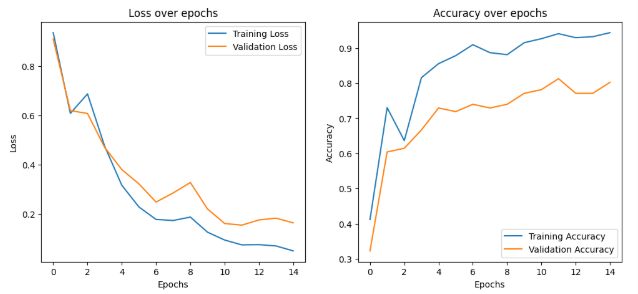

If everything was set up correctly, you'll notice that some learning happened. Well done! The results are not too bad, but we can do better. We could invest energy in preventing overfitting and improving the model, and training longer. But the biggest problem is that our dataset is small. A problem like this calls for Transfer Learning!

### Transfer Learning

With so little data, we would be well served by getting a model that's been trained on a larger dataset. The `restnet50` model we used in the lessons does well with a variety of images. Let's fetch that model and use it for Transfer Learning.

**Task 2.7.12:** Set up the `resnet50` model. We'll alter it to suit our task in subsequent steps.

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

print(model)

#output
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer3): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (5): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
)

**Task 2.7.13:** Fix the parameters of the model, so that they won't be updated when we train the model on our data.

In [ ]:
# Freeze the models weights
for params in model.parameters():
    params.requires_grad = False

print(model)

#output
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer3): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (5): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
)

Now we want to change the output layer of the model (layer `model.fc`). You'll first need to compute the number of features going into the last layer of the original model. Then you can change the last layer into:
- a dense layer with 256 neurons
- followed by ReLU activation
- then add `p=0.5` of Dropout
- followed by the output layer with 3 outputs

**Task 2.7.14:** Fill in the missing parts of code below that changes the last layer of the original model.

In [ ]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#in_features = ...
in_features = model.fc.in_features

modified_last_layer = nn.Sequential()

#dense_layer = ...
dense_layer = nn.Linear(in_features, 256)

modified_last_layer.append(dense_layer)

#relu = ...
relu = nn.ReLU()

modified_last_layer.append(relu)

modified_last_layer.append(nn.Dropout(p=0.5))

#output_layer = ...
output_layer = nn.Linear(256, 3)
modified_last_layer.append(output_layer)

# Assign `modified_last_layer` to `model.fc`
#model.fc = ...
model.fc = modified_last_layer

print(model)

#output
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer3): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (5): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

Now we're ready to train our model, but before doing so, we must re-initialize our dataset loaders in order to ensure we have a deterministic output. This is not required in production, but for this assignment is important in order to validate that you have trained the model correctly.

In [ ]:
# Important! don't change this.
g = torch.Generator()
g.manual_seed(42)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

**Task 2.7.15:** Define the loss function, create an Adam optimizer and send model to GPU device. Now we are ready to train the model for $10$ epochs.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Place the model on device
model.to(device)

# Train the model for 10 epochs
epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, loss_fn, train_loader, val_loader, epochs, device=device
)

#output
Epoch: 1
    Training loss: 0.65
    Training accuracy: 0.79
    Validation loss: 0.60
    Validation accuracy: 0.74
Epoch: 2
    Training loss: 0.26
    Training accuracy: 0.93
    Validation loss: 0.28
    Validation accuracy: 0.82
Epoch: 3
    Training loss: 0.13
    Training accuracy: 0.93
    Validation loss: 0.17
    Validation accuracy: 0.83
Epoch: 4
    Training loss: 0.06
    Training accuracy: 0.95
    Validation loss: 0.11
    Validation accuracy: 0.85
Epoch: 5
    Training loss: 0.05
    Training accuracy: 0.95
    Validation loss: 0.08
    Validation accuracy: 0.85
Epoch: 6
    Training loss: 0.03
    Training accuracy: 0.96
    Validation loss: 0.08
    Validation accuracy: 0.85
Epoch: 7
    Training loss: 0.02
    Training accuracy: 0.96
    Validation loss: 0.07
    Validation accuracy: 0.86
Epoch: 8
    Training loss: 0.02
    Training accuracy: 0.96
    Validation loss: 0.08
    Validation accuracy: 0.85
Epoch: 9
    Training loss: 0.01
    Training accuracy: 0.96
    Validation loss: 0.09
    Validation accuracy: 0.84
Epoch: 10
    Training loss: 0.01
    Training accuracy: 0.96
    Validation loss: 0.05
    Validation accuracy: 0.86

Let's again plot the learning curve and train and validation accuracies.

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

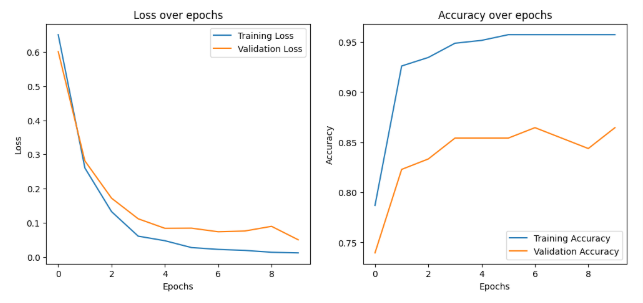

This looks a bit better. Also notice that we reached better performance with fewer epochs of training with Transfer Learning.

Now that we have a good model, we can use it to classify the test data where we don't know the correct labels.

**Task 2.7.16:** Create a dataset for the test data.  The data is located in the `potato_dataset/test` directory. Then make a data loader from this data set and make sure to **not** shuffle this data! We'll use a smaller batch size here (`batch_size = 10`) because the test dataset contains only 35 images.

In [ ]:
from training import predict

test_dir = os.path.join("potato_dataset", "test")

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_norm)

batch_size = 10

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of test images:", len(test_dataset))

#output
Number of test images: 35


We want to know the right category (healthy, early blight, or late blight) for each test image. We're not asked for the probabilities, so we'll need to get the actual predicted categories. Someone else looking at this won't know what our class numbers mean, so there is also code that turns the numbers into names.

**Task 2.7.17:** Make a prediction for each of the test images.

In [ ]:
# Predict the probabilities for each test image
test_probabilities = predict(model, test_loader, device)

# Get the index associated with the largest probability for each test image
test_predictions = torch.argmax(test_probabilities, dim=1)

# Converts the class index to the class name for each test image.
test_classes = [train_dataset.dataset.classes[i] for i in test_predictions]

print("Number of predictions:", test_predictions.shape)
print("Predictions (class index):", test_predictions.tolist())
print()
print("Predictions (class name):", test_classes)

#output
Number of predictions: torch.Size([35])
Predictions (class index): [1, 0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 1, 0, 1]

Predictions (class name): ['Potato_Late_blight', 'Potato_Early_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_healthy', 'Potato_Late_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_healthy', 'Potato_healthy', 'Potato_healthy', 'Potato_Late_blight', 'Potato_healthy', 'Potato_Late_blight', 'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy', 'Potato_healthy', 'Potato_Late_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_Late_blight', 'Potato_Early_blight', 'Potato_Late_blight']

### Training with Callbacks

The learning curve we obtained after training this model suggests that we've likely fit long enough. But a couple more epochs could help. The best way would be to just train for very long, but stop when training stops improving. This requires us using Callbacks.

In lesson `025-callbacks`, we modified the training loop to include a few callbacks. That code is in this assignment's `training.py`, but it's now named `train_callback`. Let's import it.

In [ ]:
from training import train_callbacks

In [ ]:
train_callbacks?

#output
Signature:
train_callbacks(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device='cpu',
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
)
Docstring: <no docstring>
File:      /app/training.py
Type:      function

**Task 2.7.18:** Continue training the model for another 50 epochs and make sure to include Early Stopping and Checkpointing. You'll need to define the checkpointing path, use `"LR_model.pth"`. For `early_stopping_function`, there's an `early_stopping` function in the `training.py`. Import that and use it.

In [ ]:
# Import the early_stopping function
from training import early_stopping

epochs_to_train = 50
checkpoint_path = "LR_model.pth"
early_stopping_function = early_stopping

train_results = train_callbacks(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    checkpoint_path=checkpoint_path,
    early_stopping=early_stopping_function,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results


#output
Model evaluation before start of training...


Starting epoch 1/50
Epoch: 1
Training loss: 0.0005
Training accuracy: 95.74%
Validation loss: 0.0330
Validation accuracy: 86.46%
Checkpoint saved with validation loss 0.0330


Starting epoch 2/50
Epoch: 2
Training loss: 0.0013
Training accuracy: 95.74%
Validation loss: 0.1510
Validation accuracy: 81.25%


Starting epoch 3/50
Epoch: 3
Training loss: 0.0005
Training accuracy: 95.74%
Validation loss: 0.0366
Validation accuracy: 86.46%


Starting epoch 4/50
Epoch: 4
Training loss: 0.0005
Training accuracy: 95.74%
Validation loss: 0.0285
Validation accuracy: 86.46%
Checkpoint saved with validation loss 0.0285


Starting epoch 5/50
Epoch: 5
Training loss: 0.0004
Training accuracy: 95.74%
Validation loss: 0.0437
Validation accuracy: 85.42%


Starting epoch 6/50
Epoch: 6
Training loss: 0.0007
Training accuracy: 95.74%
Validation loss: 0.1184
Validation accuracy: 82.29%


Starting epoch 7/50
Epoch: 7
Training loss: 0.0008
Training accuracy: 95.74%
Validation loss: 0.0470
Validation accuracy: 86.46%


Starting epoch 8/50
Epoch: 8
Training loss: 0.0007
Training accuracy: 95.74%
Validation loss: 0.0322
Validation accuracy: 86.46%


Starting epoch 9/50
Epoch: 9
Training loss: 0.0005
Training accuracy: 95.74%
Validation loss: 0.0474
Validation accuracy: 85.42%
Early stopping triggered after 9 epochs

With early stopping, the model trained a few epochs past the best model. But the checkpointing saved that best model. Let's load it.

**Task 2.7.19:** Load the saved best model from the checkpointing.

In [ ]:
# Load the model with `torch.load`
checkpoint = torch.load("LR_model.pth")

# Load model state dictionaries
model.load_state_dict(checkpoint["model_state_dict"])

print(model)


#output
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer3): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (5): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

And with that best model, we should be able to improve our predictions.

**Task 2.7.20:** Use the loaded best model to make predictions on each test image.

In [ ]:
# Predict the probabilities for each test image
test_probabilities = predict(model, test_loader, device)

# Get the index associated with the largest probability for each test image
test_predictions = torch.argmax(test_probabilities, dim=1)

# Converts the class index to the class name for each test image.
test_classes = [train_dataset.dataset.classes[i] for i in test_predictions]

print("Number of predictions:", test_predictions.shape)
print("Predictions (class index):", test_predictions.tolist())
print()
print("Predictions (class name):", test_classes)


#output
Number of predictions: torch.Size([35])
Predictions (class index): [1, 0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 1, 0, 1]

Predictions (class name): ['Potato_Late_blight', 'Potato_Early_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_healthy', 'Potato_Late_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_healthy', 'Potato_healthy', 'Potato_healthy', 'Potato_Late_blight', 'Potato_healthy', 'Potato_Late_blight', 'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy', 'Potato_healthy', 'Potato_Late_blight', 'Potato_Early_blight', 'Potato_healthy', 'Potato_Early_blight', 'Potato_Late_blight', 'Potato_Early_blight', 'Potato_Late_blight']